In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from ema import read

df = read.ax6_summary()
df

,residents_id,accel_date,n_valid_all,avg_inact_mins_all,avg_light_mins_all,avg_mod_mins_all,avg_vig_mins_all,avg_mvpa_mins_all,avg_wake_mins_all,avg_sleep_mins_all,...,zbmi,bmicat,zbmi_change,organised_PA,ph_9_mean,paq_score,PE_related_PA,school_recreational_PA,outside_school_PA,weekend_PA
0,40.0,2022-04-24,4.0,731.687988,228.395996,28.542000,2.000,30.542,990.625000,449.375000,...,0.266155,Healthy weight,0.535745,1.173913,1.857143,2.447895,quite often,1.5,3.5,4.0
1,41.0,2022-04-24,5.0,691.732971,282.450012,35.382999,1.283,36.666,1010.849976,429.149994,...,1.003298,Overweight,-0.117251,1.217391,2.142857,2.151139,I dont do PE,1.5,2.5,4.0
2,42.0,2022-04-24,4.0,958.583008,216.979004,26.958000,0.833,27.791,1203.354004,236.645996,...,-1.037208,Underweight,-2.153997,1.739130,3.000000,1.748792,I dont do PE,1.0,2.0,2.0
3,46.0,2022-04-21,3.0,892.250000,194.722000,21.833000,0.250,22.083,1109.056030,330.944000,...,0.057294,Healthy weight,-0.311795,1.086957,1.857143,1.660455,I dont do PE,1.5,2.0,3.0
4,110.0,2022-04-18,1.0,853.416992,142.667007,23.500000,0.500,24.000,1020.083008,419.916992,...,2.790148,Obese,-0.754868,1.608696,2.857143,1.718426,quite often,1.5,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,39814.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.196305,Obese,0.580453,1.347826,2.142857,1.832298,I dont do PE,1.0,2.0,3.0
622,39829.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.547819,Overweight,0.289909,1.043478,1.000000,1.115942,I dont do PE,1.0,1.0,1.0
623,39830.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.504402,Obese,0.243121,1.434783,2.000000,2.603865,quite often,2.0,3.0,4.0
624,39831.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.509202,Healthy weight,0.518500,1.000000,1.000000,1.222222,sometimes,1.0,1.0,1.0


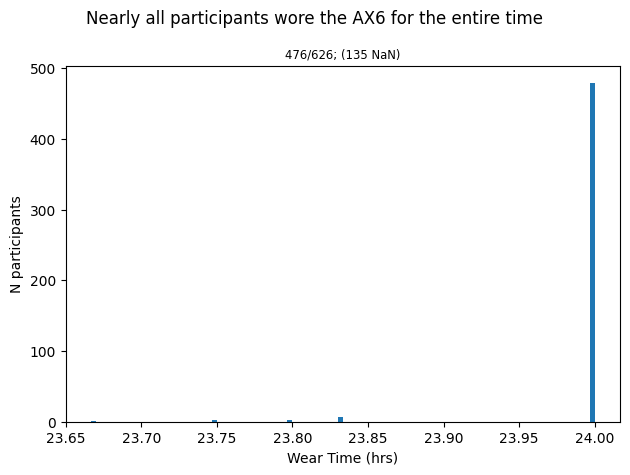

In [3]:
import numpy as np
import matplotlib.pyplot as plt

img_dir = "img/ax6"
if not os.path.isdir(img_dir):
    os.mkdir(img_dir)

col = "avg_wtime_mins_all"

fig, axis = plt.subplots()

weartime_hrs = df[col] / 60
axis.hist(weartime_hrs, bins=100)

axis.set_xlabel("Wear Time (hrs)")
axis.set_ylabel("N participants")

fig.suptitle("Nearly all participants wore the AX6 for the entire time")
axis.set_title(
    f"{(weartime_hrs == 24).sum()}/{len(df)}; ({weartime_hrs.isna().sum()} NaN)",
    fontsize="small",
)

fig.tight_layout()

fig.savefig(f"{img_dir}/ax6_wear_time_hist.png")

In [4]:
"""
Read in the GGIR data

"""
person_summary = read.ax6_person_summary(part=2)

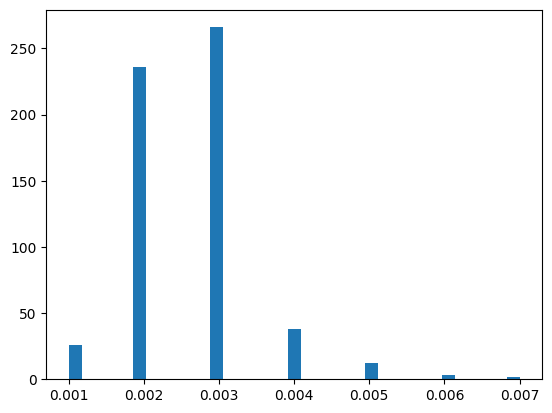

In [5]:
"""
Plot a histogram of GGIR wear time

"""
_ = plt.hist(person_summary["calib_err"], bins=35)

In [6]:
"""
Summarise the data quality report

"""
data_quality_df = read.ax6_data_quality()

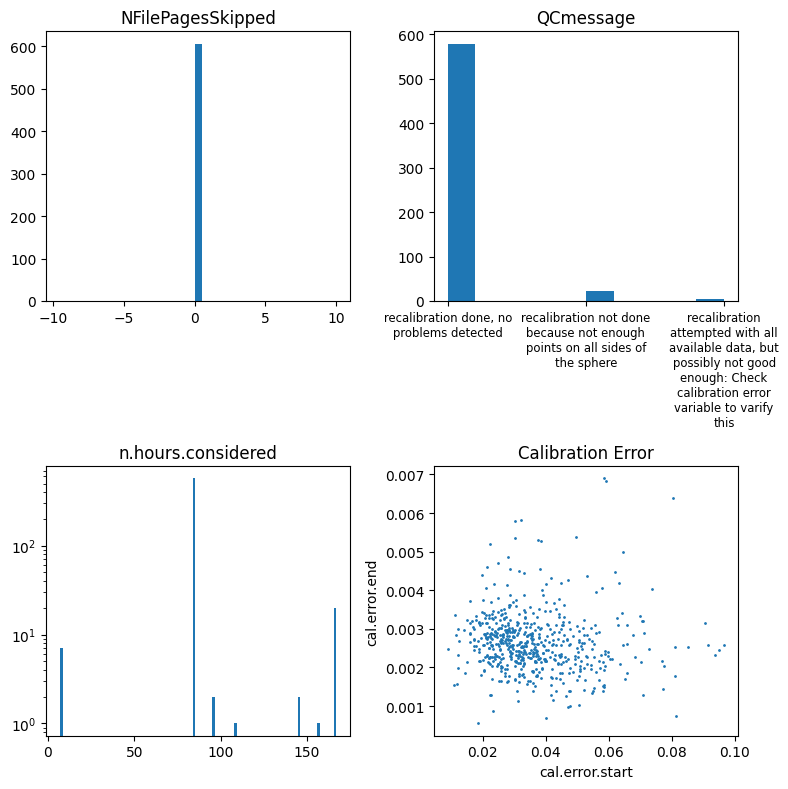

In [83]:
from textwrap import wrap
import pandas as pd

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

col = "NFilePagesSkipped"
axes[0, 0].set_title(col)
axes[0, 0].hist(data_quality_df[col], bins=np.arange(-10, 10, 0.5) + 0.5)

col = "QCmessage"
axes[0, 1].set_title(col)
axes[0, 1].hist(data_quality_df[col])
axes[0, 1].set_xticks(
    np.arange(0, 3),
    ["\n".join(wrap(label.get_text(), 22)) for label in axes[0, 1].get_xticklabels()],
    ha="center",
    fontsize="small",
)

col = "n.hours.considered"
axes[1, 0].set_title(col)
axes[1, 0].hist(data_quality_df[col], bins=100)
axes[1, 0].set_yscale("log")
data_quality_df[col].value_counts()

col = "cal.error.end"
error_start = pd.to_numeric(data_quality_df["cal.error.start"], errors="coerce")
error_end = pd.to_numeric(data_quality_df["cal.error.end"], errors="coerce")
axes[1, 1].scatter(error_start, error_end, s=1)
axes[1, 1].set_xlabel("cal.error.start")
axes[1, 1].set_ylabel("cal.error.end")
axes[1, 1].set_title("Calibration Error")

fig.tight_layout()

In [11]:
"""
Visualise the person-level summary:
    - clipping score
    - Measurement duration
    - Wear duration
    - Completeness score
    - Calibration Status
    - Total number of valid days

"""

'\nVisualise the person-level summary:\n    - clipping score\n    - Measurement duration\n    - Wear duration\n    - Completeness score\n    - Calibration Status\n    - Total number of valid days\n\n'

In [ ]:
"""
Visualise the day-level summary:
    - number of hours of measurement
    - number of hours with valid data
    - sleep/wake times as a nice column heatmap thing

"""